# Inception Architecture

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

### Inception model

In [12]:
kernel_init = glorot_uniform()
bias_init = constant(value=0.2)


def inception_module(x, filter_1x1, filter_3x3_reduce, filter_3x3, filter_5x5_reduce, filter_5x5, filters_pool_proj,
                     name=None):
    conv_1x1 = Conv2D(filter_1x1, kernel_size=(1, 1), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(x)
    # 3x3 layer
    conv_3x3_reduce = Conv2D(filter_3x3_reduce, kernel_size=(1, 1), padding='same', activation=relu,
                             kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filter_3x3, kernel_size=(3, 3), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(conv_3x3_reduce)
    # 5x5 layer
    conv_5x5_reduce = Conv2D(filter_5x5_reduce, kernel_size=(1, 1), padding='same', activation=relu,
                             kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filter_5x5, kernel_size=(5, 5), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(conv_5x5_reduce)
    # pool projection layer
    pool_proj = MaxPooling2D(pool_size=(3, 3), padding='same', strides=(1, 1))(x)
    pool_proj = Conv2D(filters_pool_proj, kernel_size=(1, 1), padding='same', activation=relu,
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

# bottom layer
input_layer = Input(shape=(96,96,3))
x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', activation=relu, kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPooling2D(pool_size=(2,2),padding='same', name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same', activation=relu, kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same', activation=relu, kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2),padding='same', name='max_pool_2_3x3/2')(x)

# inception layers
x = inception_module(x,filter_1x1=64,filter_3x3_reduce=96,filter_3x3=128,filter_5x5_reduce=16,filter_5x5=32,filters_pool_proj=32,name='inception_3a')
x = inception_module(x,filter_1x1=128,filter_3x3_reduce=128,filter_3x3=192,filter_5x5_reduce=32,filter_5x5=96,filters_pool_proj=64,name='inception_3b')
x = MaxPooling2D(pool_size=(2,2), padding='same',name='max_pool_3_3x3/2')(x)

x = inception_module(x,filter_1x1=192,filter_3x3_reduce=96,filter_3x3=208,filter_5x5_reduce=16,filter_5x5=48,filters_pool_proj=64,name='inception_4a')
x = inception_module(x,filter_1x1=160,filter_3x3_reduce=112,filter_3x3=224,filter_5x5_reduce=24,filter_5x5=64,filters_pool_proj=64,name='inception_4b')
x = inception_module(x,filter_1x1=128,filter_3x3_reduce=128,filter_3x3=256,filter_5x5_reduce=24,filter_5x5=64,filters_pool_proj=64,name='inception_4c')
x = inception_module(x,filter_1x1=112,filter_3x3_reduce=144,filter_3x3=288,filter_5x5_reduce=32,filter_5x5=64,filters_pool_proj=64,name='inception_4d')
x = inception_module(x,filter_1x1=256,filter_3x3_reduce=160,filter_3x3=320,filter_5x5_reduce=32,filter_5x5=128,filters_pool_proj=128,name='inception_4e')
x = MaxPooling2D(pool_size=(2,2), padding='same',name='max_pool_4_3x3/2')(x)

x = inception_module(x,filter_1x1=256,filter_3x3_reduce=160,filter_3x3=320,filter_5x5_reduce=32,filter_5x5=128,filters_pool_proj=128,name='inception_5a')
x = inception_module(x,filter_1x1=384,filter_3x3_reduce=192,filter_3x3=384,filter_5x5_reduce=48,filter_5x5=128,filters_pool_proj=128,name='inception_5b')

# classifier
x = AveragePooling2D(pool_size=(3,3), strides=(1,1), padding='valid')(x)
x = Dropout(rate=0.4)(x)
output_layer = Dense(units=42, activation=sigmoid)(x)

exp_conv = Model(input_layer, output_layer)

exp_conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_352 (Conv2D)            (None, 48, 48, 64)   9472        ['input_8[0][0]']                
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 24, 24, 64)  0           ['conv2d_352[0][0]']             
 )                                                                                                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 24, 24, 64)  256         ['max_pool_1_3x3/2[0][0]']   

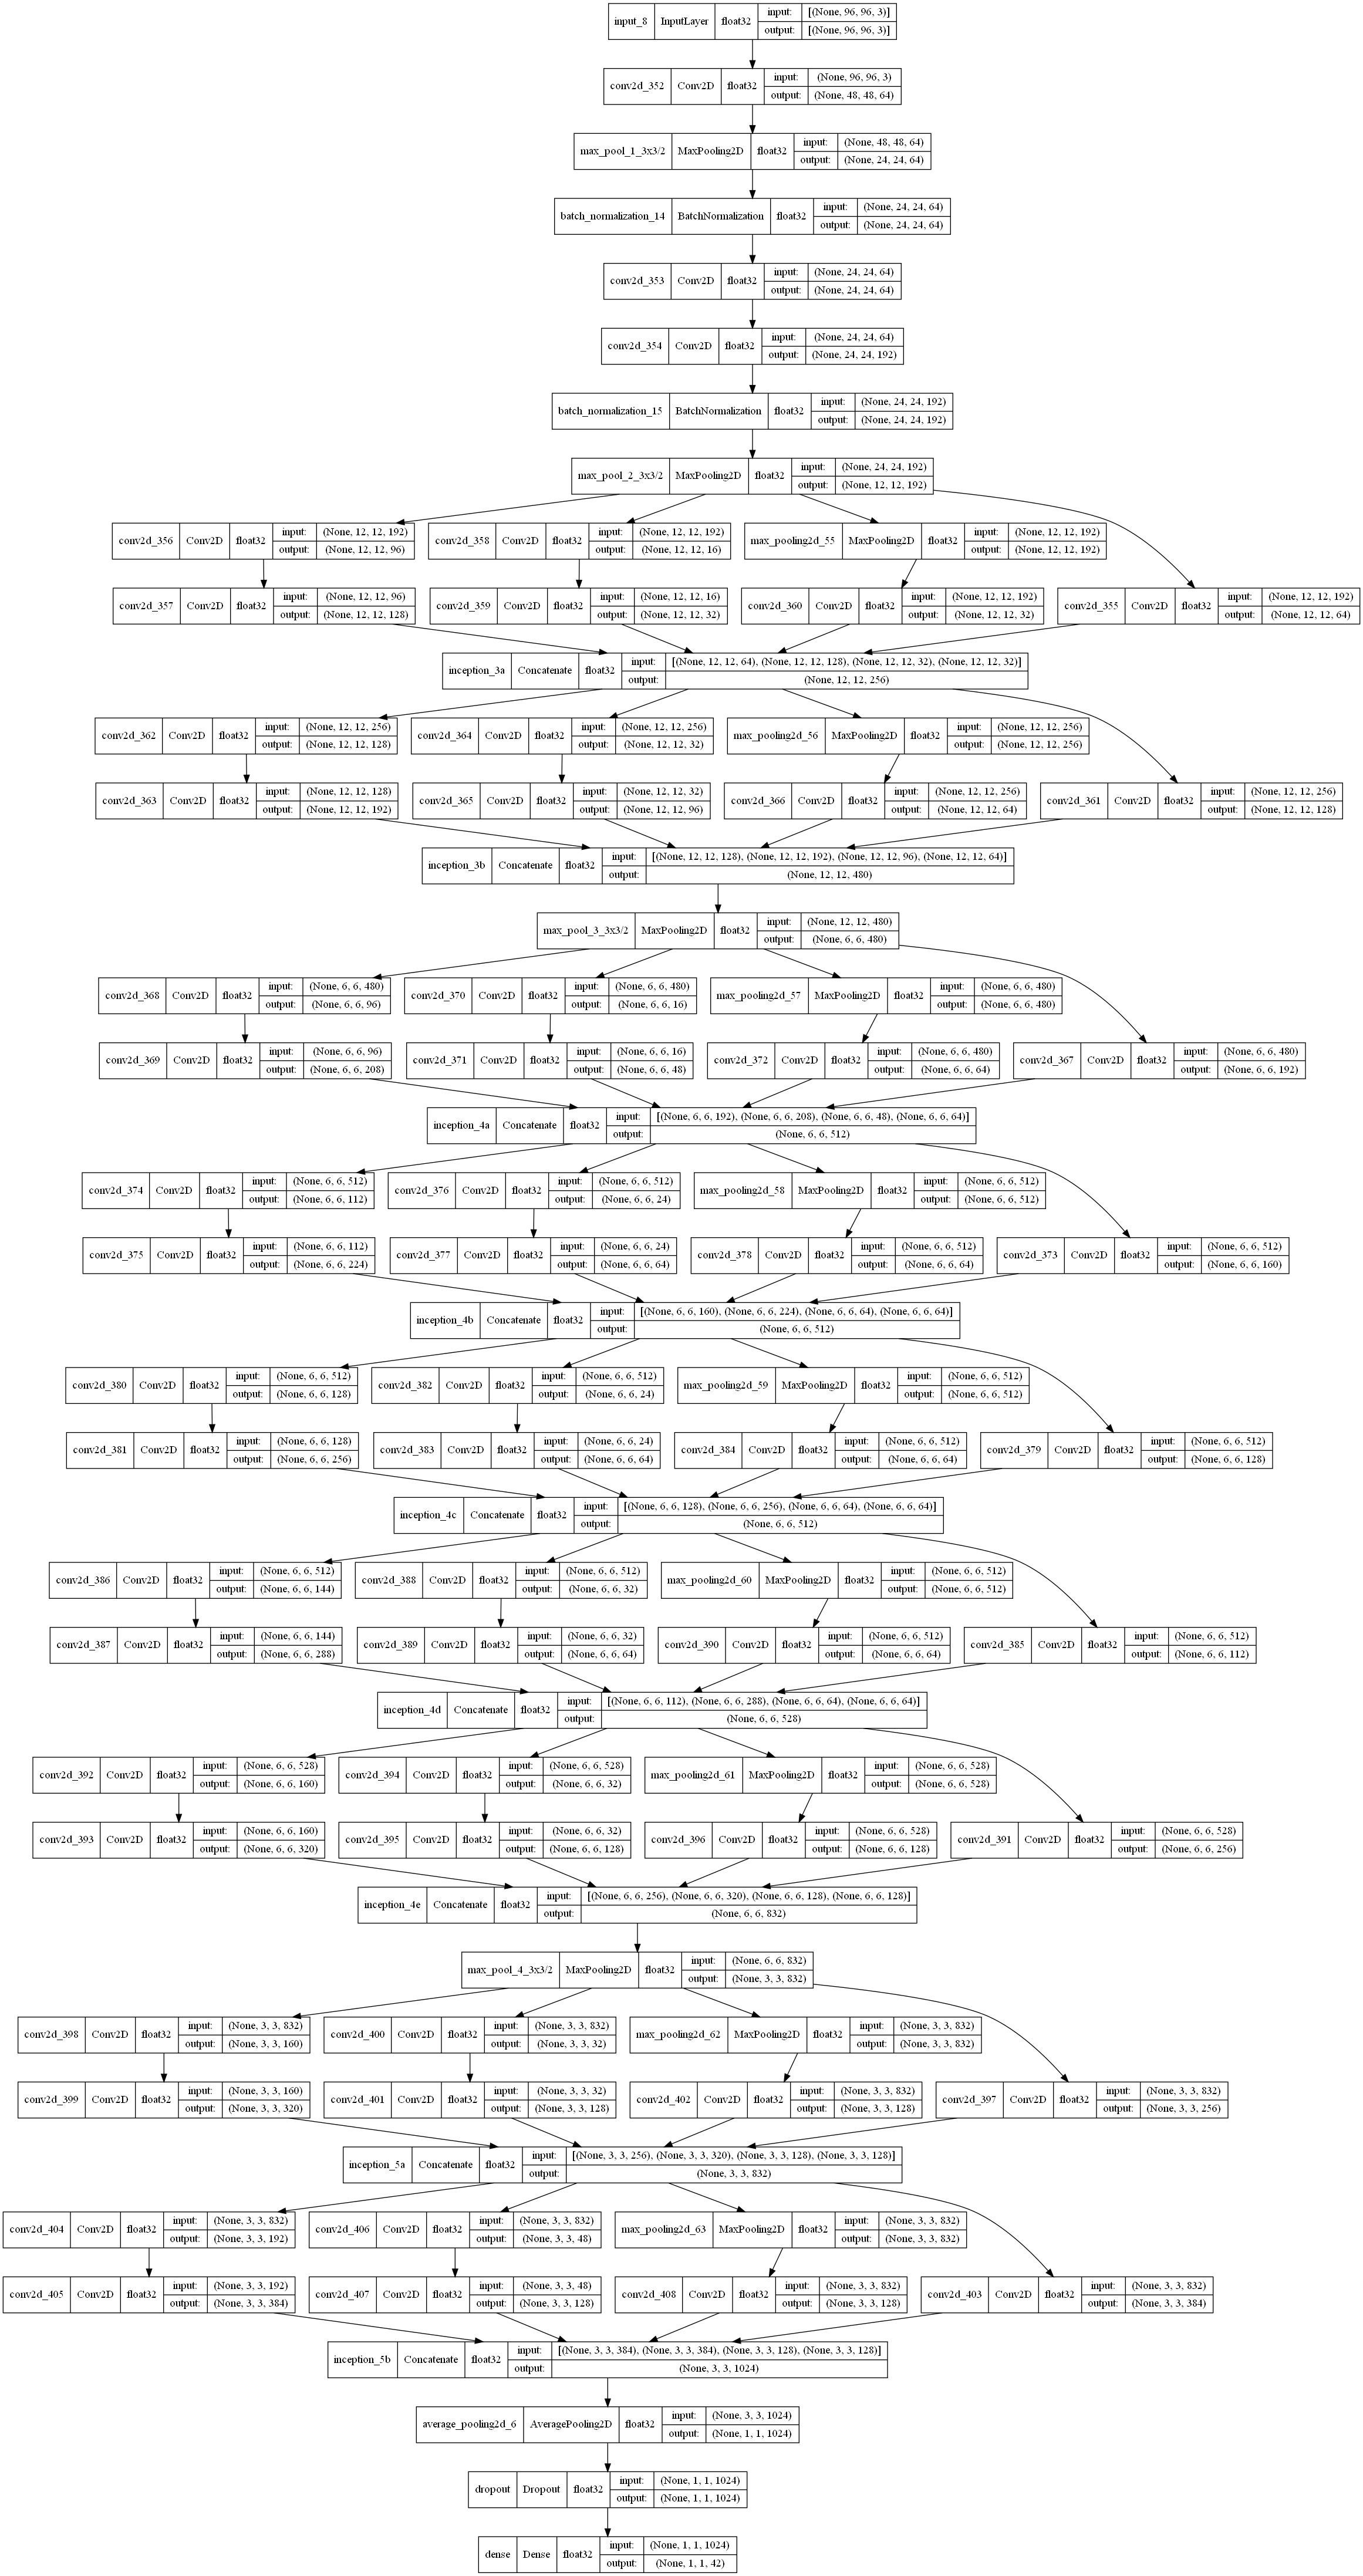

In [13]:
plot_model(model=exp_conv,
           to_file='Inception.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [4]:
tree_types = os.listdir('../input/leaf-disease-dataset-combination/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../input/leaf-disease-dataset-combination/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(96, 96)))
            X.append(image)
            y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('../input/leaf-disease-dataset-combination/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(96, 96)))
            val_x.append(image)
            val_y.append([tree, disease])


In [5]:
X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
generator = ImageDataGenerator(rescale=1. / 255)

In [6]:
X.shape, y.shape, val_x.shape, val_y.shape

((38104, 56, 56, 3), (38104, 42), (9458, 56, 56, 3), (9458, 42))

In [7]:
train_gen = generator.flow(X, y, batch_size=64)
val_gen = generator.flow(val_x, val_y, batch_size=64)

#### training

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='Inception.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=25,
                               restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stopping]

In [9]:
exp_conv.compile(optimizer=Adam(),
                 loss=binary_crossentropy,
                 metrics=['accuracy'])

In [10]:
exp_conv_history = exp_conv.fit(train_gen,
                                epochs=200,
                                callbacks=callbacks,
                                validation_data=val_gen)

2022-01-09 15:42:53.478109: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-09 15:42:55.733430: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


596/596 [==============================] - 41s 55ms/step - loss: 0.1042 - accuracy: 0.2572 - val_loss: 0.1659 - val_accuracy: 0.1392
Epoch 2/200
596/596 [==============================] - 33s 55ms/step - loss: 0.0583 - accuracy: 0.3387 - val_loss: 0.0633 - val_accuracy: 0.4357
Epoch 3/200
596/596 [==============================] - 32s 54ms/step - loss: 0.0430 - accuracy: 0.3715 - val_loss: 0.0541 - val_accuracy: 0.4272
Epoch 4/200
596/596 [==============================] - 32s 54ms/step - loss: 0.0355 - accuracy: 0.3774 - val_loss: 0.1174 - val_accuracy: 0.2984
Epoch 5/200
596/596 [==============================] - 32s 54ms/step - loss: 0.0293 - accuracy: 0.3861 - val_loss: 0.0510 - val_accuracy: 0.4527
Epoch 6/200
596/596 [==============================] - 32s 54ms/step - loss: 0.0239 - accuracy: 0.3896 - val_loss: 0.0383 - val_accuracy: 0.3802
Epoch 7/200
596/596 [==============================] - 32s 54ms/step - loss: 0.0215 - accuracy: 0.4091 - val_loss: 0.0987 - val_accuracy: 0.32

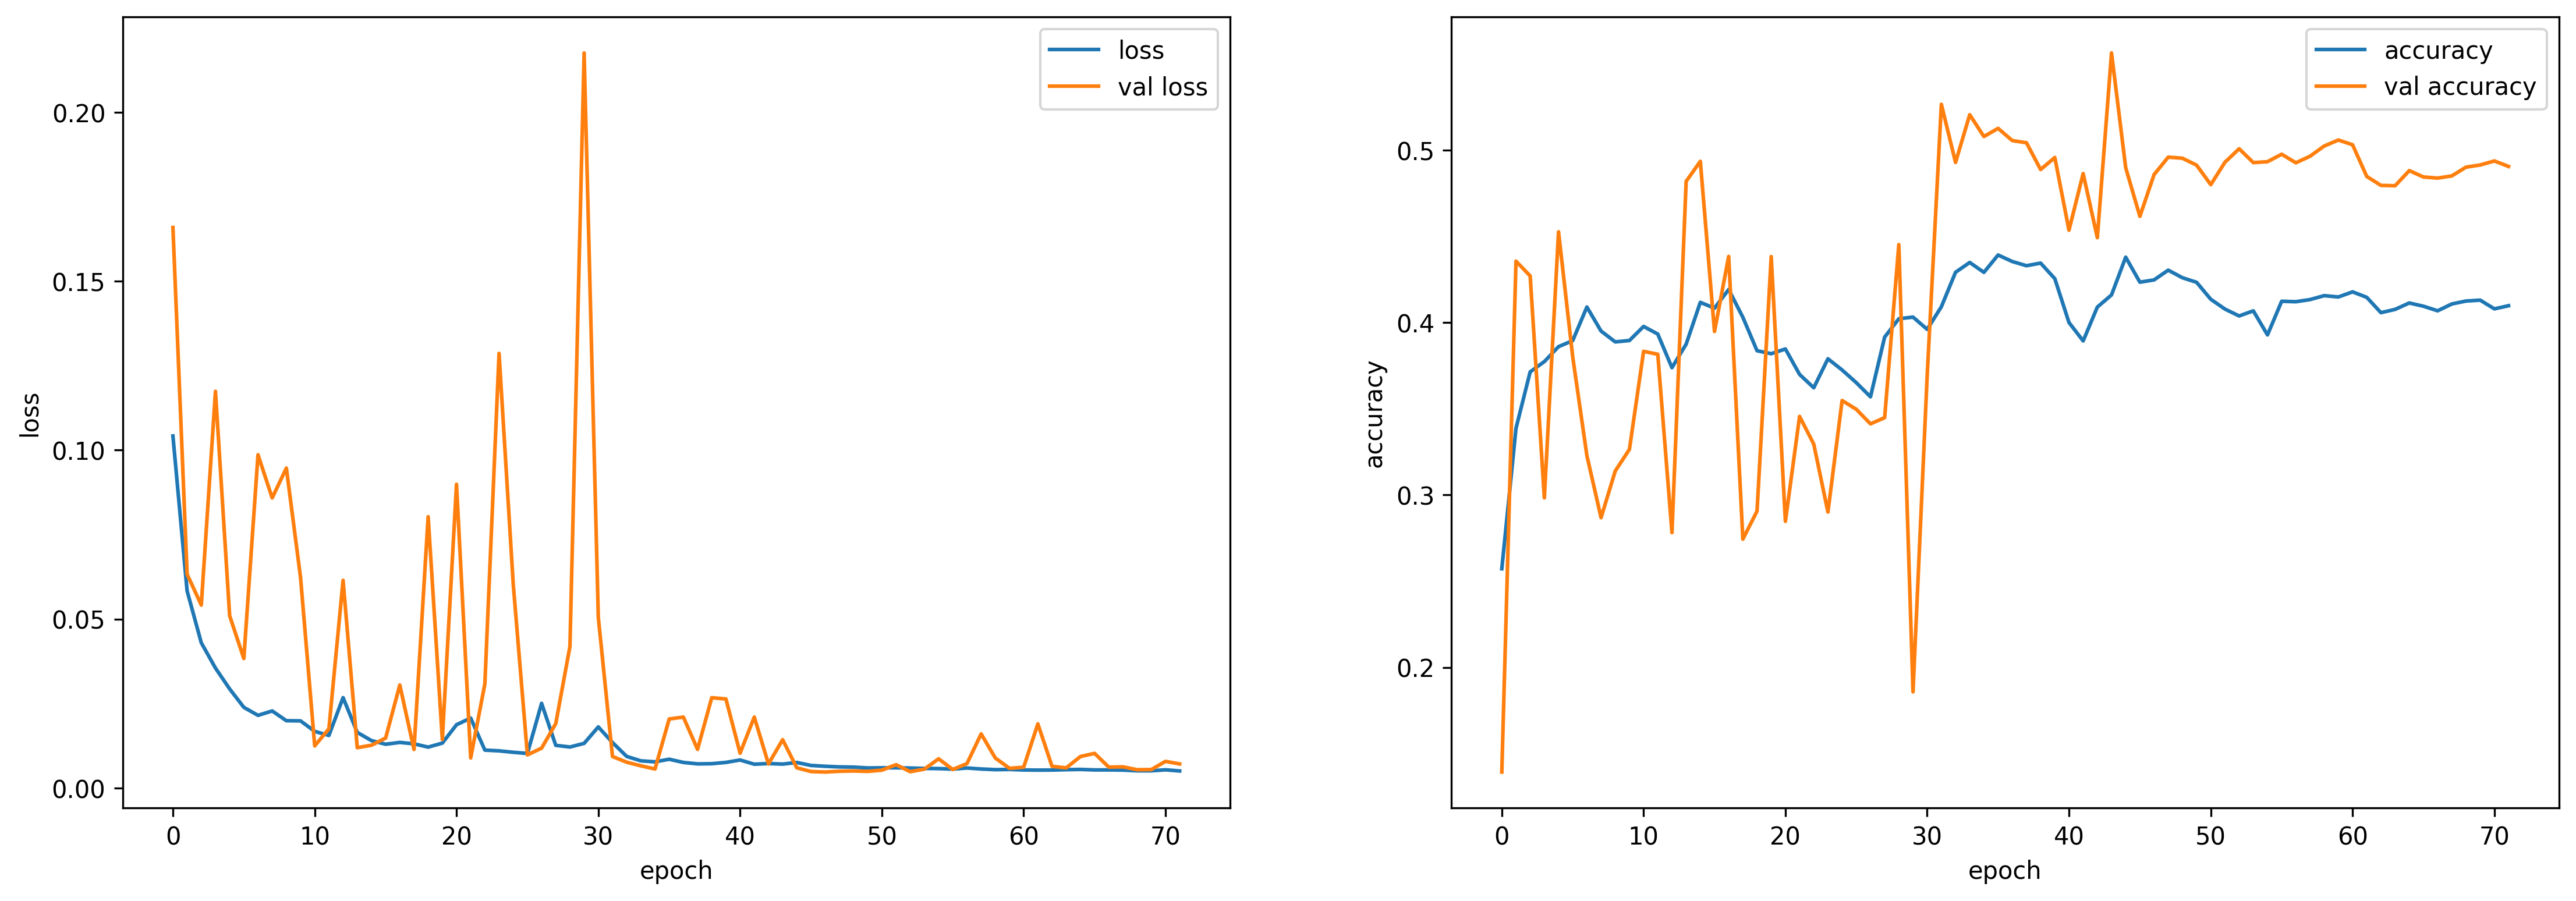

In [13]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(exp_conv_history.history['loss'])))

sns.lineplot(x=epochs, y=exp_conv_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('Inception_train_history.png')
plt.show()